# Plot observed leads on the nextsim grid in Beaufort Sea 

In [1]:
# allow plots to be interactive in the notebook
%matplotlib notebook
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import cmocean
import argparse
import locale 
from pynextsim.projection_info import ProjectionInfo
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator

In [2]:

def get_transect(xr, start_time, end_time, xpoint, ypoint):

    '''
    xr: DataArray with variable to get transect of
    
    '''
    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = xr.sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    yvals = np.linspace(y_slice.start, y_slice.stop, length) 

    print(yvals.shape, vtimes.shape, transect.shape)

    return yvals, vtimes, transect

def plot_map(ax):

    lons = ds.longitude[:] #dims:y,x
    lats = ds.latitude[:]

    # find lon,lat coordinates for x,y points
    lon0 = lons[ypoint[0]][xpoint[0]]
    lon1 = lons[ypoint[1]][xpoint[1]]
    lat0 = lats[ypoint[0]][xpoint[0]]
    lat1 = lats[ypoint[1]][xpoint[1]]
    lon = (lon0, lon1)
    lat = (lat0, lat1)
    
    proj = ccrs.NorthPolarStereo(central_longitude=-45)
    ax.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], crs=ax.projection) 

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1) 
    ax.coastlines(resolution='50m', linewidth=0.5) 
    ax.gridlines(draw_labels=False, linestyle='dotted')
    ax.plot(lon, lat, 'ro-', transform=ccrs.Geodetic()) # geodetic plots shortest distance 
    ax.patch.set_alpha(0.5)

def plot_transect(ax, outdir, moorings_file, add_insetmap=True):
    global clabel, figname, cmap, clim, cb_extend
    clabel, figname, cmap, clim, cb_extend = _PLOT_INFO[vname]
    
    print("Start plotting", vname)
    #fig = plt.figure(figsize=(8, 3))
    #fig.subplots_adjust(bottom=0.2, top=0.90, left=0.1, right=0.95, wspace=0.01, hspace=0.01)
    #ax = fig.add_subplot(111)
    
    if np.size(clim)==2: #contineous colormap 
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
        vmin=clim[0], vmax=clim[1], cmap=cmap, extend=cb_extend)
    else: #discrete colormap
        clevs = np.arange(clim[0], clim[1]+clim[2],clim[2])
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
            levels=clevs, cmap=cmap, extend=cb_extend)

    # add colorbar
    #cax,kw = mpl.colorbar.make_axes(ax,location='right')
    cax = fig.add_axes([0.915, 0.2, 0.01, 0.5])
    cbar=fig.colorbar(cf,cax=cax)
    cbar.set_label(clabel)
    #cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    #cbar.set_label(clabel)  

    # set labels
    locale.setlocale(locale.LC_ALL,'en_US')  # change language to EN
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    ax.xaxis.set_major_formatter(dtFmt)
    ax.xaxis.set_minor_locator(days)
    plt.xticks(rotation=45) # rotate xlabels
    ax.set_ylabel("y")

    # add map 
    if add_insetmap:
        proj = ccrs.NorthPolarStereo(central_longitude=-45)
        ax_inset = fig.add_axes([0.061, 0.21, 0.2, 0.4], projection=proj)
        plot_map(ax_inset) 


In [3]:
# Open ArcLeads 

arcleads = xr.open_dataset('/cluster/home/rheinlender/data/ArcLeads/ArcLeads_20130101-20130430.nc')  
latlon_grid =  xr.open_dataset('/cluster/home/rheinlender/data/ArcLeads/latlonmap.nc')
longitude = latlon_grid['longitude'][:]
latitude = latlon_grid['latitude'][:]

arcleads['longitude'] = longitude
arcleads['latitude'] = latitude

arcleads.rename({'latitude': 'lat', 'longitude': 'lon'})
arcleads.coords['lon'] = longitude
arcleads.coords['lat'] = latitude
# make lon and lat coordinates
#arcleads.set_coords(['lon', 'lat'])

leadmap = arcleads.leadMap
#leadmap.assign_coords({"lon":arcleads.longitude, "lat":arcleads.latitude})
arcleads

<xarray.Dataset>
Dimensions:    (c: 2968, r: 2968, time: 120)
Coordinates:
  * time       (time) object 2013-01-01 00:00:00 ... 2013-04-30 00:00:00
    lon        (c, r) float64 ...
    lat        (c, r) float64 ...
Dimensions without coordinates: c, r
Data variables:
    leadMap    (time, c, r) int8 ...
    longitude  (c, r) float64 ...
    latitude   (c, r) float64 ...
Attributes:
    creation_date:     27-Oct-2015 15:30:53
    surface classes:   0: land, 1: clouds, 2: sea ice, 3: artifact, 4: lead
    retrieval method:  Willmes and Heinemann (2015) Annals of Glaciology, 56(...
    history:           Mon Mar  8 16:28:55 2021: ncap2 -O -s time=array((2013...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [4]:
# Open Mooring
mooring = xr.open_dataset('/cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_01_wrf10/outputs-v11/Moorings.nc')
nlon = mooring.longitude.values
nlat = mooring.latitude.values


<xarray.Dataset>
Dimensions:                   (nv: 2, time: 223, x: 719, y: 647)
Coordinates:
  * time                      (time) datetime64[ns] 2013-02-13T01:30:00 ... 2...
Dimensions without coordinates: nv, x, y
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    longitude                 (y, x) float32 -106.37166 ... 101.307945
    latitude                  (y, x) float32 65.66971 65.710014 ... 67.25915
    siu                       (time, y, x) float32 ...
    siv                       (time, y, x) float32 ...
    wndx                      (time, y, x) float32 ...
    wndy                      (time, y, x) float32 ...
    sic                       (time, y, x) float32 ...
    sic_thin                  (time, y, x) float32 ...
    sit                       (time, y, x) float32 ...
    snt                       (time, y, x) float32 ...
    hfos                      (time, y, x) float32 ...
    hfs                       (time, y, x) float32 ...
    sfo                       (time, y, x) float32 ...
    damage                    (time, y, x) float32 ...
    hfsl                      (time, y, x) float32 ...
    hfss                      (time, y, x) float32 ...
    rls                       (time, y, x) float32 ...
    rss                       (time, y, x) float32 ...
    wspeed                    (time, y, x) float32 ...
    sit_thin                  (time, y, x) float32 ...
    sia                       (time, y, x) float32 ...
    fyi_fraction              (time, y, x) float32 ...
    ts                        (time, y, x) float32 ...
    psl                       (time, y, x) float32 ...
    del_hi                    (time, y, x) float32 ...
    del_hi_thin               (time, y, x) float32 ...
    newice                    (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    source:       neXtSIM model fields

In [5]:
# regridding the Arcleads product to the Nextsim grid

proj = ProjectionInfo() # default nextsim projection

# get destination grid; x and y grid from nextsim
dst_x,dst_y = proj.pyproj(nlon, nlat) # init grid using x,y coords of grid

# get source grid; Project lon and lat from Arcleads to x,y grid using nextsim projection
src_x,src_y = proj.pyproj(arcleads['longitude'].values, arcleads['latitude'].values) 

xtrans = src_x.transpose()
ytrans = src_y.transpose()

fig, ax = plt.subplots(1,3, figsize=(12,4))
arcleads.leadMap[100].plot.imshow(ax=ax[0], vmax=4)
ax[1].pcolormesh(xtrans,ytrans,arcleads.leadMap[100].transpose(), vmax=4)
ax[2].pcolormesh(dst_x, dst_y, mooring.sit[100], vmax=4)

ax[1].set_xlim([-2.3e6, 1.3e6])
ax[1].set_ylim([-1.2e6, 2e6])
ax[2].set_xlim([-2.3e6, 1.3e6])
ax[2].set_ylim([-1.2e6, 2e6])
ax[0].set_title('raw ArcLeads')
ax[1].set_title('reprojected ArcLeads')
ax[2].set_title('neXtSIM')


<IPython.core.display.Javascript object>

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'neXtSIM')

In [6]:
from scipy.interpolate import griddata

def Interp2NextsimGrid(src_x, src_y, src_field, dst_x, dst_y, method='nearest'):    
        '''
        Parameters:
        -----------
        src_x : 2D np.ndarray
            2D array (x,y) source points x-coords
        src_y : 2D np.ndarray
            2D array (x,y) source points y-coords    
        src_field : 2D np.ndarray
            Data values (x,y) on the source grid
        dst_x : 2D np.ndarray
            2D array (xi,yi) destination points x-coords
        dst_y : 2D np.ndarray
            2D array (xi,yi) destination points y-coords
        method : {‘linear’, ‘nearest’, ‘cubic’}
            interpolation method of scipy.interpolate.griddata (default is "nearest")

        '''
        
        # flatten 2D arrays
        points = np.array( (src_x.flatten(), src_y.flatten()) ).T

        vals = src_field.flatten()

        fld_interp = griddata(points, vals, (dst_x, dst_y), method=method)

        return fld_interp    

In [7]:
# regrid ArcLeads to Nextsim grid

# using pynextsim function
igi = IrregularGridInterpolator(src_x, src_y, dst_x, dst_y)

#  source field
src_f = arcleads.leadMap

# use the shape from dst grid
nx,ny = dst_x.shape
nt = src_f.shape[0] 

dst_f = np.zeros((nt, nx, ny))
print(dst_f.shape)
# loop over time axis in source field
for t,time in enumerate(src_f.time):
    #print(t)
    
    vals = src_f.isel(time=[t]).squeeze().values
    
#    dst_f[t,:,:] = Interp2NextsimGrid(src_x, src_y, vals, dst_x, dst_y, method='nearest')
    dst_f[t,:,:] = igi.interp_field(vals, method='nearest')

    break
print('done!')


(120, 647, 719)
done!


In [9]:
# convert interpolated leadmap product back to DataArray

leadmap = dst_f
time = arcleads.indexes['time'].to_datetimeindex()
surface_classes = arcleads.attrs['surface classes']

ds = xr.Dataset(
    data_vars=dict(
        leadmap=(["time", "y", "x"], leadmap),    ),

    coords=dict(
        time=time,    ),

    attrs=dict(
        description="ArcLeads product interpolated on to the nextsim grid.",
        surface_classes= surface_classes),
)

ds

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


<xarray.Dataset>
Dimensions:  (time: 120, x: 719, y: 647)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-04-30
Dimensions without coordinates: x, y
Data variables:
    leadmap  (time, y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:      ArcLeads product interpolated on to the nextsim grid.
    surface_classes:  0: land, 1: clouds, 2: sea ice, 3: artifact, 4: lead

In [10]:
# compare raw and interpolated fields
    
fig, ax = plt.subplots(1,2, figsize=(15,6))
    
# define colors
col_dict={0:"darkgrey",
          1:"black",
          2:"ghostwhite",
          3:"peru",
          4:"mediumblue"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# get colorbar tick labels 
attr = ds.attrs['surface_classes']

labels={0:"land",
        1:"clouds",
        2:"sea ice",
        3:"artifact",
        4:"lead"}

len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.
norm_bins = np.insert(norm_bins, 5, np.max(norm_bins) + 1.0)

## Make normalizer and formatter
norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# prepare plot
leadMap = arcleads.leadMap.sel(time="2013-02-24").squeeze()
leadMap_interp = ds.leadmap.sel(time="2013-02-24")
lons = arcleads.longitude
lats = arcleads.latitude
    
print(leadMap.shape, leadMap_interp.shape)
    
im = ax[0].pcolormesh(dst_x, dst_y, leadMap_interp, cmap=cm, norm=norm)
im2 = ax[1].pcolormesh(xtrans,ytrans,leadMap.transpose(),  cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cax,kw = mpl.colorbar.make_axes(ax,location='right',
                                   format=fmt,
                                   ticks=tickz)
out=fig.colorbar(im,cax=cax,**kw)
    
ax[0].set_title("interpolated")
ax[1].set_title("raw")
plt.show()
    
for axs in ax.flat:
    axs.set_xlim([-2.3e6, -0.8e6])
    axs.set_ylim([-0.5e6, 1e6])

<IPython.core.display.Javascript object>

(2968, 2968) (647, 719)


/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


# Plot observed lead propagation along transect

In [11]:
# main

outdir =  '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
vname='leadmap'

# Create slice variables subset domain
start_time = '2013-02-11'
end_time = '2013-03-15'
xpoint = (100, 100)
ypoint = (180, 450)

print("Get transect from", start_time, "to", end_time)
yvals, vtimes, transect = get_transect(ds[vname],start_time, end_time, xpoint, ypoint)


Get transect from 2013-02-11 to 2013-03-15
(270,) (33,) (33, 270)


<IPython.core.display.Javascript object>


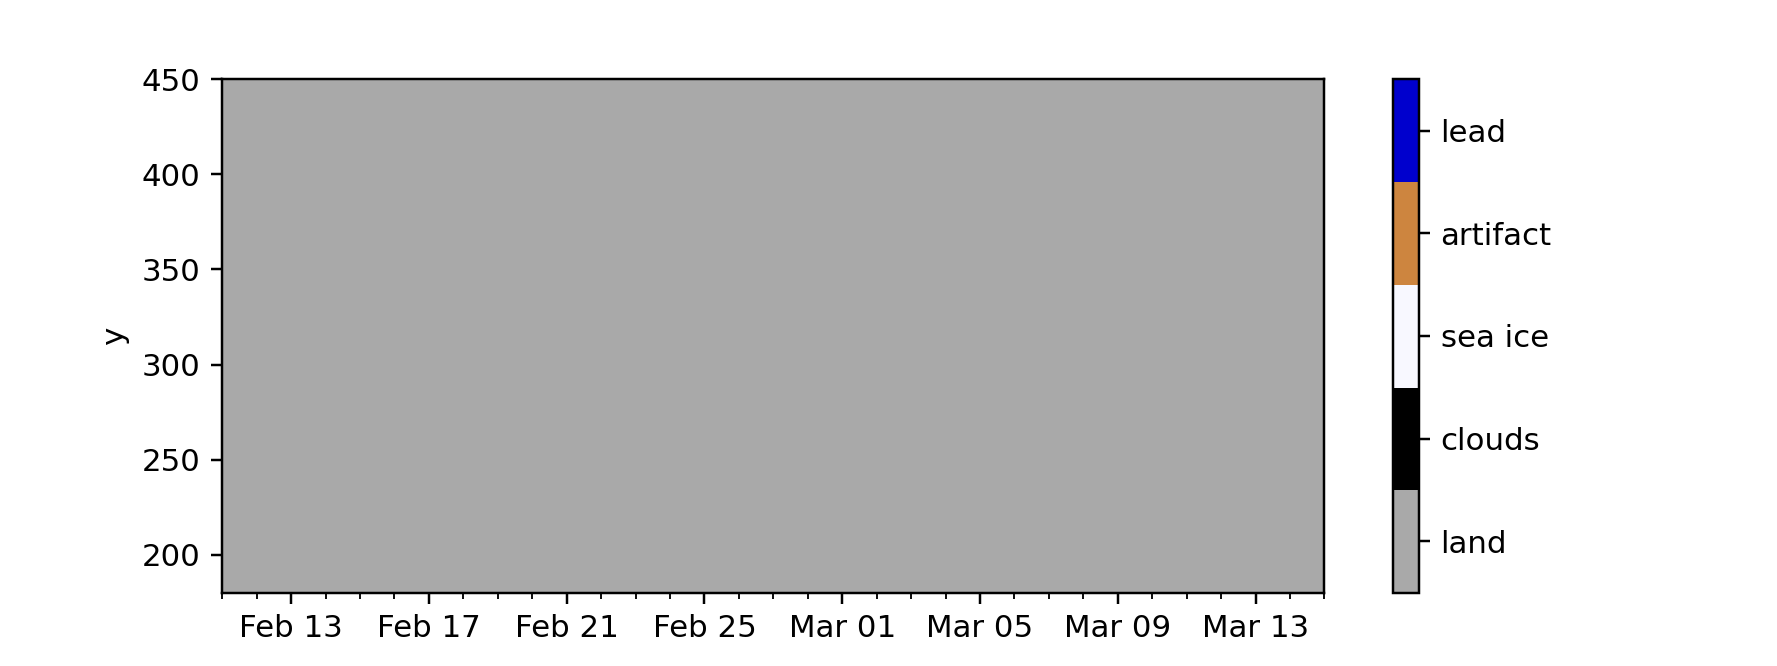

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [12]:

plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(8,3)) #create one of the figures that must appear with the chart

# define colors
col_dict={0:"darkgrey",
          1:"black",
          2:"ghostwhite",
          3:"peru",
          4:"mediumblue"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# get colorbar tick labels 
attr = ds.attrs['surface_classes']

labels={0:"land",
        1:"clouds",
        2:"sea ice",
        3:"artifact",
        4:"lead"}

len_lab = len(labels)

# prepare normalizer
norm_bins = np.sort([*col_dict.keys()])+ 0
norm_bins = np.insert(norm_bins, 5, np.max(norm_bins)+1)

## Make normalizer and formatter
norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

cf = ax.pcolormesh(vtimes, yvals, transect.transpose(), cmap=cm, norm=norm)
plt.show()

# set labels
locale.setlocale(locale.LC_ALL,'en_US')  # change language to EN
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
#plt.xticks(rotation=45) # rotate xlabels
ax.set_ylabel("y")

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cax,kw = mpl.colorbar.make_axes(ax,location='right',
                                format=fmt,
                                ticks=tickz)
out=fig.colorbar(cf,cax=cax,**kw)

